In [1]:
import pandas as pd
from sklearn.discriminant_analysis import StandardScaler
from sklearn.model_selection import train_test_split
from collections import Counter
from torch.utils.data import Dataset, DataLoader
import time
import numpy as np
from sklearn.utils import resample
# from sklearn.decomposition import FactorAnalysis, IncrementalPCA, FastICA, PCA
from sklearn.model_selection import StratifiedKFold
import torch
import torch.nn as nn
from matplotlib import pyplot as plt

from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score


In [2]:
from dataset.preparation import convert_to_gigital_target

In [3]:
csv = '/Users/alinakozyreva/Documents/MIPT/3_семестр/ВКР/datasets/CIC_IOT_Dataset2023/csv/part-00164-363d1ba3-8ab5-4f96-bc25-4d5862db7cb9-c000.csv'

In [4]:
df = pd.read_csv(csv)

In [5]:
RANDOM_STATE = 42
num_features = 46
EPOCH = 10  # train the training data n times
BATCH_SIZE = 64
INPUT_SIZE = num_features  # rnn input size
LR = 0.008  # learning rate

In [6]:
class CustomDataset(Dataset):
    def __init__(self, features, labels):
        self.features = features
        self.labels = labels

    def __len__(self):
        return (len(self.labels))

    def __getitem__(self, index):  
        return self.features[index], self.labels[index]

In [7]:
df = convert_to_gigital_target(df, classification_type='group')

In [8]:
# classic

X = df.iloc[:, 0:-1].values # [:, 0:-1]: выбирает все строки (:) и все столбцы, кроме последнего (0:-1)
y = df['label'].values

print(Counter(df['label']))

# create trainset and testset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_STATE, stratify=y)

scaler = StandardScaler()

X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# ipca = IncrementalPCA(n_components=num_features)
# # ipca.partial_fit(X_train)
# X_train = ipca.fit_transform(X_train)
# X_test = ipca.transform(X_test)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=RANDOM_STATE, stratify=y_train)


Counter({1: 325396, 2: 77652, 3: 25516, 0: 10687, 5: 4703, 4: 3340, 6: 231, 7: 113})


In [9]:
num_partitions = 10
max_partitions_size = 10_000
val_ratio = 0.2

In [10]:
# trainloaders = []
# valloaders = []
# Stratified
skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
for i, (train_index, test_index) in enumerate(skf.split(X_train, y_train)):
    X_train_part, y_train_part = X_train[train_index], y_train[train_index]
    trainset_for_one = np.column_stack([X_train_part, y_train_part])
    
    if len(trainset_for_one) > max_partitions_size:
        trainset_for_one = resample(trainset_for_one, replace=False, n_samples=max_partitions_size, random_state=RANDOM_STATE)
    
    X_val_part, y_val_part = X_train[test_index], y_train[test_index]
    valset_for_one = np.column_stack([X_val_part, y_val_part])
    
    max_len_val = int(len(trainset_for_one) * val_ratio)
    if len(valset_for_one) > max_len_val:
        valset_for_one = resample(valset_for_one, replace=False, n_samples=max_len_val, random_state=RANDOM_STATE)
    
    if i == 0:
        data = Counter(trainset_for_one[:, -1])
        print(data, sum(data.values()))
        train_set = CustomDataset(trainset_for_one[:, :-1], trainset_for_one[:, -1])
        val_set = CustomDataset(valset_for_one[:, :-1], valset_for_one[:, -1])
        train_loader = DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True)
        val_loader = DataLoader(val_set, batch_size=BATCH_SIZE, shuffle=True)
    
    # trainloaders.append(trainloader)
    # valloaders.append(valloader)


Counter({1.0: 7258, 2.0: 1762, 3.0: 560, 0.0: 218, 5.0: 119, 4.0: 80, 7.0: 2, 6.0: 1}) 10000


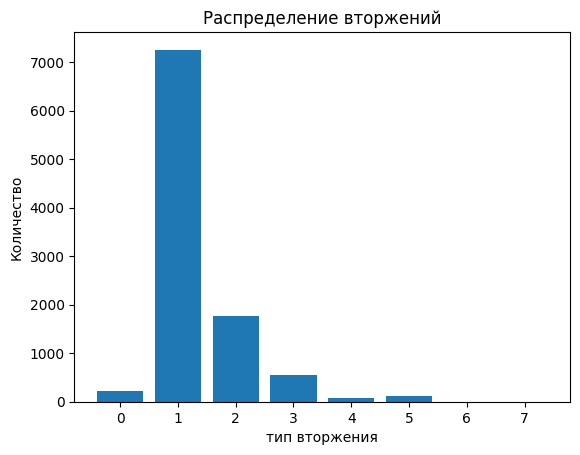

In [11]:

labels, values = zip(*data.items())

fig, ax = plt.subplots()
ax.bar(labels, values)

ax.set_xlabel('тип вторжения')
ax.set_ylabel('Количество')
ax.set_title('Распределение вторжений')

plt.show()

In [12]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [13]:
class BiLSTM(nn.Module):
    def __init__(self, num_classes: int):
        super(BiLSTM, self).__init__()
        self.lstm = nn.LSTM(
            input_size=INPUT_SIZE,
            hidden_size=32,
            bidirectional=True,
        )
       
        self.fc = nn.Linear(32 * 2, num_classes)

    def forward(self, x):
        x = x.transpose(0, 1) 
        r_out, (h_n, h_c) = self.lstm(x)
        r_out = r_out[-1]  
        model = self.fc(r_out) 
        return model

bilstm = BiLSTM(num_classes=34).to(device=device)

print(bilstm)
print(bilstm.parameters)
optimizer = torch.optim.Adam(bilstm.parameters(), lr=LR)  
torch.optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.1, last_epoch=-1)
loss_func = nn.CrossEntropyLoss()  

total = sum([param.nelement() for param in bilstm.parameters()])
print("Number of parameter: %.2fM" % (total / 1e6))

BiLSTM(
  (lstm): LSTM(46, 32, bidirectional=True)
  (fc): Linear(in_features=64, out_features=34, bias=True)
)
<bound method Module.parameters of BiLSTM(
  (lstm): LSTM(46, 32, bidirectional=True)
  (fc): Linear(in_features=64, out_features=34, bias=True)
)>
Number of parameter: 0.02M


In [14]:
# classic
test_data = CustomDataset(X_test, y_test)
test_loader = DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=True)

In [15]:
def train(model, trainloader, optimizer, epochs, device: str):
    criterion = torch.nn.CrossEntropyLoss()
    model.train()
    model.to(device)

    for epoch in range(epochs):
        print(epoch)
        for step, (x, y) in enumerate(train_loader):
            x, y = x.to(device), y.to(device)
            x = x.view(-1, 1, INPUT_SIZE).float()
            optimizer.zero_grad()
            loss = criterion(model(x), y)
            loss.backward()
            optimizer.step()

def test(model, testloader, device: str):
    criterion = torch.nn.CrossEntropyLoss()
    loss = 0.0
    predicts = []
    labels = []
    model.eval()
    model.to(device)
    
    with torch.no_grad():
        for step, (x, y) in enumerate(testloader):
            x, y = x.to(device), y.to(device)
            x = x.view(-1, 1, INPUT_SIZE).float()
            outputs = model(x)
            loss += criterion(outputs, y)
            _, predicted = torch.max(outputs.data, 1)

            # for metrics   
            # Collect predictions and true labels for later use in calculating metrics
            predicts.extend(predicted)
            labels.extend(y.numpy())

    accuracy = accuracy_score(labels, predicts)
    precision = precision_score(labels, predicts, average='weighted')
    recall = recall_score(labels, predicts, average='weighted')
    f1 = f1_score(labels, predicts, average='weighted')
    
    return loss, accuracy, precision, recall, f1

In [16]:
# classic
all_val_precision, all_val_recall, all_val_f1, all_val_accuracy = [], [], [], []
epoch_start_global = time.time()
for epoch in range(EPOCH):
    epoch_start_time = time.time()
    train_acc, train_loss = 0.0, 0.0
    val_acc, val_loss = 0.0, 0.0
    
    train_predicts = []
    train_labels = []

    bilstm.train()  
    for step, (b_x, b_y) in enumerate(train_loader):  
        b_x = b_x.view(-1, 1, INPUT_SIZE).float()
        b_y = b_y.long()
        train_pred = bilstm(b_x)# rnn output
        loss = loss_func(train_pred, b_y)  
        optimizer.zero_grad() 
        loss.backward() 
        optimizer.step() 

        train_acc += np.sum(np.argmax(train_pred.cpu().data.numpy(), axis=1) == b_y.numpy())
        train_loss += loss.item()

        # Collect predictions and true labels for later use in calculating metrics
        train_predicts.extend(np.argmax(train_pred.cpu().data.numpy(), axis=1))
        train_labels.extend(b_y.numpy())

    bilstm.eval()
    with torch.no_grad():
        predicts = []
        labels = []
        for step, (a_x, a_y) in enumerate(val_loader):
            a_x = a_x.view(-1, 1, INPUT_SIZE).float()
            a_y = a_y.long()
            val_pred = bilstm(a_x)
            loss = loss_func(val_pred, a_y)
            val_acc += np.sum(np.argmax(val_pred.cpu().data.numpy(), axis=1) == a_y.numpy())
            val_loss += loss.item()

            # Collect predictions and true labels for later use in calculating metrics
            predicts.extend(np.argmax(val_pred.cpu().data.numpy(), axis=1))
            labels.extend(a_y.numpy())

    # Calculate precision, recall, and F1 score for both training and validation sets
    train_precision = precision_score(train_labels, train_predicts, average='weighted', zero_division=1)
    train_recall = recall_score(train_labels, train_predicts, average='weighted', zero_division=1)
    train_f1 = f1_score(train_labels, train_predicts, average='weighted')
    train_accuracy = accuracy_score(train_labels, train_predicts)

    val_precision = precision_score(labels, predicts, average='weighted', zero_division=1)
    val_recall = recall_score(labels, predicts, average='weighted', zero_division=1)
    val_f1 = f1_score(labels, predicts, average='weighted')
    val_accuracy = accuracy_score(labels, predicts)

    # to list    
    all_val_precision.append(val_precision)
    all_val_recall.append(val_recall)
    all_val_f1.append(val_f1)
    all_val_accuracy.append(val_accuracy)

    print('[%03d/%03d] %2.2f sec(s) Val Loss: %3.6f  Precision: %3.6f Recall: %3.6f F1: %3.6f Accuracy: %3.6f' % \
          (epoch + 1, EPOCH, time.time() - epoch_start_time, \
        val_loss / val_set.__len__(), 
        val_precision, val_recall, val_f1, val_accuracy, 
           ))

print('training time: %2.2f sec(s) '% (time.time()-epoch_start_global))

[001/010] 0.66 sec(s) Val Loss: 0.005910  Precision: 0.819935 Recall: 0.827000 F1: 0.779342 Accuracy: 0.827000
[002/010] 0.42 sec(s) Val Loss: 0.005659  Precision: 0.812097 Recall: 0.829000 F1: 0.790825 Accuracy: 0.829000
[003/010] 0.39 sec(s) Val Loss: 0.005946  Precision: 0.826758 Recall: 0.830500 F1: 0.783682 Accuracy: 0.830500
[004/010] 0.47 sec(s) Val Loss: 0.005646  Precision: 0.826353 Recall: 0.834000 F1: 0.792015 Accuracy: 0.834000
[005/010] 0.83 sec(s) Val Loss: 0.005460  Precision: 0.854681 Recall: 0.856000 F1: 0.830039 Accuracy: 0.856000
[006/010] 0.26 sec(s) Val Loss: 0.005625  Precision: 0.842998 Recall: 0.853000 F1: 0.844356 Accuracy: 0.853000
[007/010] 0.36 sec(s) Val Loss: 0.005558  Precision: 0.835779 Recall: 0.813500 F1: 0.820514 Accuracy: 0.813500
[008/010] 0.75 sec(s) Val Loss: 0.005404  Precision: 0.841373 Recall: 0.844500 F1: 0.813224 Accuracy: 0.844500
[009/010] 0.38 sec(s) Val Loss: 0.005154  Precision: 0.852224 Recall: 0.860500 F1: 0.846496 Accuracy: 0.860500
[

In [17]:
bilstm.eval()
with torch.no_grad():
    test_predicts = []
    test_labels = []
    test_acc, test_loss = 0.0, 0.0

    for step, (a_x, a_y) in enumerate(test_loader):
        a_x = a_x.view(-1, 1, INPUT_SIZE).float()
        test_pred = bilstm(a_x)
        loss = loss_func(test_pred, a_y)

        test_acc += np.sum(np.argmax(test_pred.cpu().data.numpy(), axis=1) == a_y.numpy())
        test_loss += loss.item()

        # Collect predictions and true labels for later use in calculating metrics
        test_predicts.extend(np.argmax(test_pred.cpu().data.numpy(), axis=1))
        test_labels.extend(a_y.numpy())

test_precision = precision_score(test_labels, test_predicts, average='weighted', zero_division=1)
test_recall = recall_score(test_labels, test_predicts, average='weighted', zero_division=1)
test_f1 = f1_score(test_labels, test_predicts, average='weighted')
test_accuracy = accuracy_score(test_labels, test_predicts)    

print('%2.2f sec(s) Test Loss: %3.6f Precision: %3.6f Recall: %3.6f F1: %3.6f Accuracy: %3.6f' % \
      (time.time() - epoch_start_time, test_loss / test_data.__len__(), test_precision, test_recall, test_f1, test_accuracy)
     )   

1.02 sec(s) Test Loss: 0.004615 Precision: 0.880917 Recall: 0.885645 F1: 0.877309 Accuracy: 0.885645


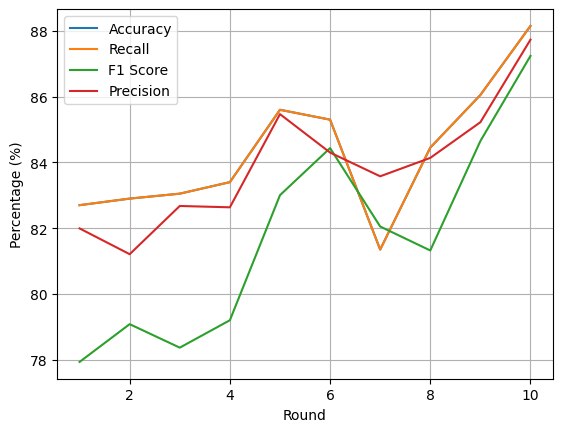

In [18]:
from matplotlib import pyplot as plt

round = list(range(1, EPOCH + 1))
acc = [100.0 * value for value in all_val_accuracy]
recall = [100.0 * value for value in all_val_recall]
f1 = [100.0 * value for value in all_val_f1]
precision = [100.0 * value for value in all_val_precision]

plt.plot(round, acc, label='Accuracy')
plt.plot(round, recall, label='Recall')
plt.plot(round, f1, label='F1 Score')
plt.plot(round, precision, label='Precision')

plt.grid()
plt.xlabel('Round')
plt.ylabel('Percentage (%)')
plt.legend()
plt.show()